<a id='top'></a><a name='top'></a>
# Chapter 4: Word and Sentence Embeddings

## 4.3 Multilingual embeddings

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/gbih/nlp/blob/main/ja_nlp_book/chp04_4_3_multilingual_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

* [Imports and Setup](#setup)
* [4.3 Multilingual embeddings](#4.3)
    - [4.3.1 What are multilingual embeddings?](#4.3.1)
    - [4.3.2 Using Universal Sentence Encoder to Embed Japanese and English Texts](#4.3.2)
    - [4.3.3 Finding Translations Between Japanese and English](#4.3.3)

---
<a name='setup'></a><a id='setup'></a>
# Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
from pathlib import Path

data_root = Path("chp04_03")
req_file = data_root / "requirements_4_4_3.txt"

if not data_root.is_dir():
    data_root.mkdir()
else:
    print(f"{data_root} exists.")

chp04_03 exists.


In [11]:
%%writefile {req_file}
annoy==1.17.1
fugashi[unidic]==1.2.1
gensim==4.2.0
japanize_matplotlib==1.1.3
tensorflow-datasets==4.6.0
tensorflow-hub==0.12.0
tensorflow-text==2.9.0
watermark==2.3.1

Overwriting chp04_03/requirements_4_4_3.txt


In [12]:
import sys
import os
check1 = ('google.colab' in sys.modules)
check2 = (os.environ.get('CLOUDSDK_CONFIG')=='/content/.config')
IS_COLAB = True if (check1 or check2) else False

if IS_COLAB:
    print("Installing packages")
    !pip install --quiet -r {req_file}
    !python -m unidic download
    print("Packages installed.")
else:
    print("Running locally.")

Installing packages
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:27<00:00, 18.8MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.8/dist-packages/unidic/dicdir
Packages installed.


In [13]:
# Standard Library imports
from importlib.metadata import version
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlog log messages
import shlex
import subprocess
import sys

# Third-party imports
from collections import Counter
from annoy import AnnoyIndex
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import tensorflow_hub as hub
import tensorflow_text # Need for the Google USE model
import tensorflow_datasets as tfds
from tqdm import tqdm
from tqdm import trange
from watermark import watermark

def HR():
    print("-"*50)

# Examine all imported packages
print(watermark(iversions=True, globals_=globals(),python=True, machine=False))

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

matplotlib         : 3.2.2
sys                : 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
tensorflow_hub     : 0.12.0
tensorflow_text    : 2.9.0
japanize_matplotlib: 1.1.3
tensorflow_datasets: 4.6.0
numpy              : 1.21.6



In [14]:
assert version('annoy') == '1.17.1'
assert version('fugashi') == '1.2.1'
assert version('gensim') == '4.2.0'
assert version('japanize_matplotlib') == '1.1.3'
assert version('tensorflow-datasets') == '4.6.0'
assert version('tensorflow-hub') == '0.12.0'
assert version('tensorflow-text') == '2.9.0'

print("Successfully imported specified packages.")

Successfully imported specified packages.


In [15]:
data_url = "https://github.com/facebookresearch/LASER"
data_dir = Path("chp04_02")
data_path = data_dir / "LASER"

print(f"""
data_url:\t{data_url}
data_dir:\t{data_dir}
data_path:\t{data_path}
""")


data_url:	https://github.com/facebookresearch/LASER
data_dir:	chp04_02
data_path:	chp04_02/LASER



---
<a name='4.3'></a><a id='4.3'></a>
# 4.3 Multilingual embeddings
<a href="#top">[back to top]</a>

<a name='4.3.1'></a><a id='4.3.1'></a>
## 4.3.1 What are multilingual embeddings?
<a href="#top">[back to top]</a>

<a name='4.3.2'></a><a id='4.3.2'></a>
## 4.3.2 Using Universal Sentence Encoder to Embed Japanese and English Texts
<a href="#top">[back to top]</a>

Download Google Universal Sentence Encoder (USE) model and use as a function.

In [16]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
print("USE Model loaded")

USE Model loaded


In [17]:
# Compute the embeddings for some simple sentences.
japanese_sentences = ["犬", "子犬はいいです", "私は犬と一緒にビーチを散歩するのが好きです"]
english_sentences = ["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."]

en_result = embed(english_sentences)
ja_result = embed(japanese_sentences)

print(en_result.shape)
HR()
print(ja_result.shape)
HR()

# Compute the 3x3 similarity matrix by taking the inner product
# between combination of the input lists.
np.inner(en_result, ja_result)

(3, 512)
--------------------------------------------------
(3, 512)
--------------------------------------------------


array([[0.9171356 , 0.51152694, 0.3158718 ],
       [0.44313586, 0.6586347 , 0.3092131 ],
       [0.26650533, 0.25377443, 0.7672991 ]], dtype=float32)

### Use the USE model to encode Wikipedia articles and retrieve them based on the vector similarity

* Here we are using the embeddings computed by USE, not the Doc2Vec model.
* Take the first 10K Wikipedia articles and embed them using USE.

In [18]:
# Quick reminder of inner-products:
a = np.array([[1,2], [3,4]]) 
print('Array a:')
print(a) 
HR()

b = np.array([[11, 12], [13, 14]]) 
print('Array b:')
print(b)
HR()

print('Inner product:')
print(np.inner(a,b))

Array a:
[[1 2]
 [3 4]]
--------------------------------------------------
Array b:
[[11 12]
 [13 14]]
--------------------------------------------------
Inner product:
[[35 41]
 [81 95]]


In [19]:
data_wikipedia_path = Path("chp04_shared/wikipedia_data")
print(f"data_wikipedia_path:\t{data_wikipedia_path}")

if not Path(data_wikipedia_path).is_dir():
    data_wikipedia_path.mkdir(parents=True, exist_ok=False)

data_wikipedia_path:	chp04_shared/wikipedia_data


In [20]:
# Load the Japanese Wikipedia dump
wikipedia_src='wikipedia/20200301.ja'
     
print(f"Use {wikipedia_src}")
HR()
      
ds = tfds.load(
    wikipedia_src, 
    split='train', 
    shuffle_files=True,
    data_dir = data_wikipedia_path
)

print(ds)

Use wikipedia/20200301.ja
--------------------------------------------------


Dl Completed...:   0%|          | 0/66 [00:00<?, ? file/s]

Dataset wikipedia downloaded and prepared to chp04_shared/wikipedia_data/wikipedia/20200301.ja/1.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [21]:
documents = []

for example in tqdm(tfds.as_numpy(ds.take(10_000))):
    text = example["text"].decode("utf-8").replace("\n", " ")
    documents.append(text[:100])

100%|██████████| 10000/10000 [00:03<00:00, 2643.12it/s]


In [22]:
def embed_documents(documents, embedding_func):
    batch_size = 128
    embeds = []
    
    # trange(i) is a special optimised instance of tqdm(range(i)):
    for i in trange(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        batch_embedded = embedding_func(batch).numpy()
        embeds.extend(batch_embedded)
    return embeds

In [23]:
embeds = embed_documents(documents, embed)

100%|██████████| 79/79 [00:02<00:00, 37.54it/s]


### Retrieve similar documents by calculating the similarity (inner product) between the embeddings. 

In [24]:
def get_similar_docs(orig_doc_id, embeds):
    """
    Previews 10 most similar documents for a given document.
    """
    t1 = "orig id = "
    print(f"{t1:>10}{orig_doc_id}, ttl = {documents[orig_doc_id][:30]}")
    sims = Counter({doc: sim for doc, sim in zip(documents, np.matmul(embeds, embeds[orig_doc_id]))})
    
    t2 = "doc = "
    for doc, sim in sims.most_common(10):
        print(f"{t2:>10}{doc[:20]}, sim = {sim:.2f}")

In [25]:
get_similar_docs(orig_doc_id=1, embeds=embeds)

orig id = 1, ttl = 外苑警備隊（がいえんけいびたい）は西口プロレス所属のお笑いコ
    doc = 外苑警備隊（がいえんけいびたい）は西口プ, sim = 1.00
    doc = にいみ 啓介（にいみ けいすけ、本名：新, sim = 0.54
    doc = 福来 剛（ふくらい つよし、1981年6, sim = 0.54
    doc = 辰巳 智秋（たつみ ともあき、1976年, sim = 0.51
    doc = 山口 もえ（やまぐち もえ、本名（結婚前, sim = 0.51
    doc = 西岡 賢吾（にしおか けんご、1980年, sim = 0.51
    doc = 沼崎 悠（ぬまざき ゆう、1953年5月, sim = 0.50
    doc = 向所 浩二（むかいじょ こうじ、1972, sim = 0.50
    doc = 菊田 大輔（きくた だいすけ、1988年, sim = 0.50
    doc = 桜井 ちひろ（さくらい ちひろ、1972, sim = 0.50


In [26]:
get_similar_docs(orig_doc_id=2, embeds=embeds)

orig id = 2, ttl = ジェームズ・コリンズ（James Michael Colli
    doc = ジェームズ・コリンズ（James Mic, sim = 1.00
    doc = ポール・ノーマン・テルファー（Paul , sim = 0.63
    doc = ジェームズ・ソーントン（James Th, sim = 0.63
    doc = ガリー・ステュアート・ティール（Gary, sim = 0.61
    doc = サシャ・リーター（Sascha Riet, sim = 0.61
    doc = アハマド・ブーガンマール(、Ahmed , sim = 0.60
    doc = ウェベルソン・レアンドロ・オリベイラ・モ, sim = 0.59
    doc = ヴィンセント・"ヴィニー"・サムウェイズ, sim = 0.59
    doc = リンコン（）ことカルロス・エドゥアルド・, sim = 0.58
    doc = マシュー・アラン・レッキー（, 1991, sim = 0.58


In [27]:
get_similar_docs(orig_doc_id=123, embeds=embeds)

orig id = 123, ttl = 礼拝（れいはい、らいはい、、、）は、宗教において神や仏などを
    doc = 礼拝（れいはい、らいはい、、、）は、宗教, sim = 1.00
    doc = 神像（しんぞう） 信仰の対象となるカミを, sim = 0.61
    doc = 仏心（ぶっしん）とは、仏（ほとけ）のここ, sim = 0.47
    doc = 常行三昧堂（じょうぎょうざんまいどう）と, sim = 0.45
    doc = 宗教問題（しゅうきょうもんだい）とは、宗, sim = 0.45
    doc = 祝福（しゅくふく）とは、 神が自らの恵み, sim = 0.44
    doc = 『五三経』（ごさんきょう、, パンチャッ, sim = 0.43
    doc = 八部衆（はちぶしゅう）または天龍八部衆（, sim = 0.42
    doc = 伊勢神道（いせしんとう）とは、伊勢神宮で, sim = 0.42
    doc = 東寺真言宗（とうじしんごんしゅう）は、日, sim = 0.42


<a name='4.3.3'></a><a id='4.3.3'></a>
## 4.3.3 Finding Translations Between Japanese and English
<a href="#top">[back to top]</a>

In [28]:
# Embed the LASER repo and embed the J and E sentences with USE.
if not data_path.is_dir():
    !git clone {data_url} {data_path}

Cloning into 'chp04_02/LASER'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 938 (delta 67), reused 127 (delta 51), pack-reused 787
Receiving objects: 100% (938/938), 2.90 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (370/370), done.


In [29]:
ja_sents = []
with open(f"{data_path}/data/tatoeba/v1/tatoeba.jpn-eng.jpn") as f:
    for line in f:
        ja_sents.append(line.strip())
ja_embeds = embed_documents(ja_sents, embed)

100%|██████████| 8/8 [00:00<00:00, 74.29it/s]


In [30]:
en_sents = []
with open(f"{data_path}/data/tatoeba/v1/tatoeba.jpn-eng.eng") as f:
    for line in f:
        en_sents.append(line.strip())
en_embeds = embed_documents(en_sents, embed)

100%|██████████| 8/8 [00:00<00:00, 93.18it/s]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
<ipython-input-31-dabd9f551ab0>:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


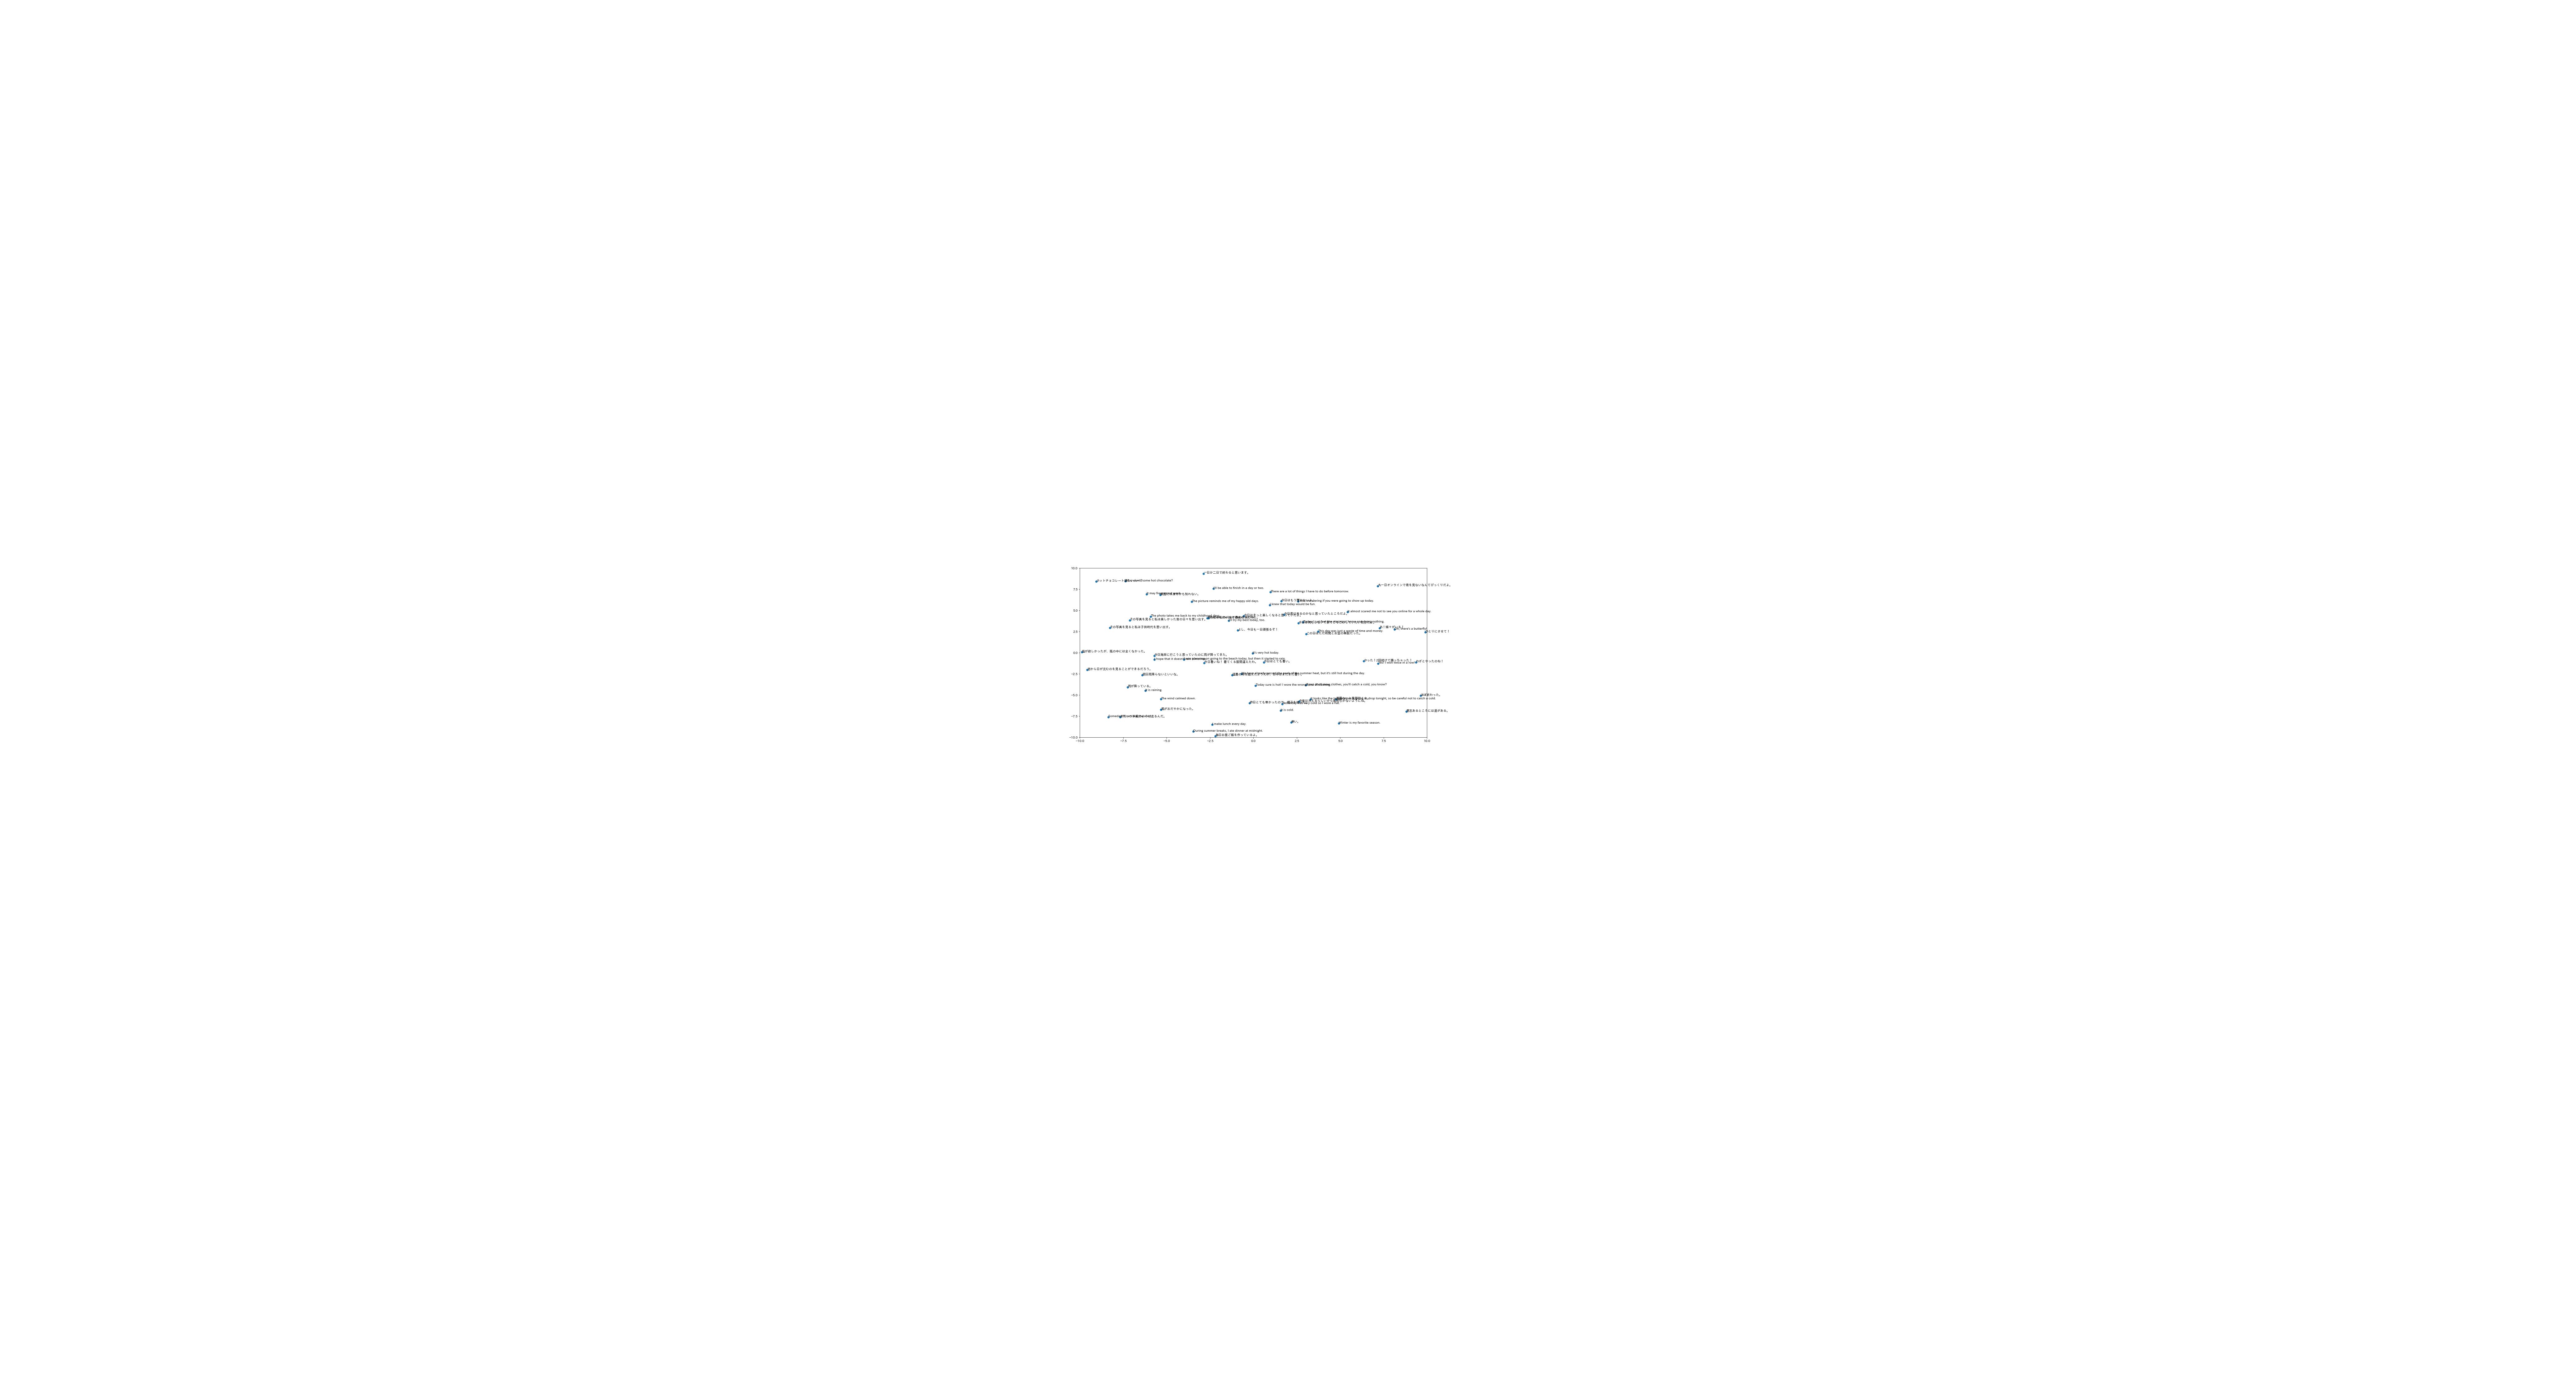

In [31]:
# Visualize the mapped sequences in the vector space using t-SNE
vectors = ja_embeds + en_embeds
labels = ja_sents + en_sents

x_embedded = TSNE(
    n_components=2, 
    random_state=42,
    learning_rate=200,
    init="pca"
).fit_transform(vectors)

x_embedded += np.random.normal(0, 1, size=(2000,2))
plt.figure(figsize=(20,10))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])

for label, x, y in zip(labels, x_embedded[:, 0], x_embedded[:, 1]):
    plt.annotate(label, (x, y))
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.tight_layout()
plt.show()

### Retrieve paired sentences based on the computed embeddings.
* Use Annoy algorithm for approximate neighbor sesarch.
* Build an index, the data structure containing the original objects to search.

In [32]:
embedding_dim = 512
idx = AnnoyIndex(f=embedding_dim, metric="angular")

for i, vec in enumerate(ja_embeds):
    idx.add_item(i, vec)
idx.build(n_trees=10)

True

### Search the index created by Annoy
* Call its `get_nns_by_vector` method while supplying the query vector.
* Search the closest vector (closest Japanese sentence) for each English sentence.
* Calculate the accuracy by counting the number of sentence pairs where the retrieved sentence is the correct one.

In [33]:
# Search the index create by Annoy
num_correct = 0
for i, vec in enumerate(en_embeds):
    best_sent_id = idx.get_nns_by_vector(vec, n=1)[0]
    if i < 20:
        print(f'OK' if i==best_sent_id else '** BAD **')
        print(f"en: {en_sents[i][:60]}")
        print(f"ja: {ja_sents[best_sent_id][:40]}")
        HR()
    num_correct += 1 if i==best_sent_id else 0
print("...")
print(f"accuracy = {num_correct / 1000}")

OK
en: Don't speak unless you have something worth saying.
ja: 言う価値のあることがなければ、しゃべるな。
--------------------------------------------------
OK
en: The principal severely reproved the students whenever they m
ja: 校長先生は、生徒が廊下を散らかしたときは、きびしく叱りました。
--------------------------------------------------
OK
en: He writes a letter.
ja: 彼は手紙を書く。
--------------------------------------------------
OK
en: She loves him all the more because he has faults.
ja: 彼女は彼に欠点があるからかえって彼を愛している。
--------------------------------------------------
OK
en: We can not learn Japanese without learning Kanji.
ja: 漢字を学ばないで日本語の勉強はできない。
--------------------------------------------------
OK
en: I learned many things about Greek culture.
ja: 私はギリシャ文明について多くのことを学びました。
--------------------------------------------------
OK
en: In other words, it takes all sorts of people to make a world
ja: 言い換えると、世の中にはいろいろな人間が必要だということだ。
--------------------------------------------------
OK
en: It's been a while since I've been here, but nothing has c

### Retrieve English sentences from Japanese queries

In [34]:
idx = AnnoyIndex(f=embedding_dim, metric="angular")

for i, vec in enumerate(en_embeds):
    idx.add_item(i, vec)
idx.build(n_trees=10)

True

In [35]:
# Search the index create by Annoy
num_correct = 0
print(len(ja_embeds))
HR()
for i, vec in enumerate(ja_embeds):
    best_sent_id = idx.get_nns_by_vector(vec, n=1)[0]
    if i < 20:
        print(idx.get_nns_by_vector(vec, n=1)[0])
        print(f'OK' if i==best_sent_id else '** BAD **')
        print(f"ja: {ja_sents[i][:40]}")
        print(f"en: {en_sents[best_sent_id][:60]}")
        HR()
    num_correct += 1 if i==best_sent_id else 0
print("...")
print(f"accuracy = {num_correct / 1000}")

1000
--------------------------------------------------
0
OK
ja: 言う価値のあることがなければ、しゃべるな。
en: Don't speak unless you have something worth saying.
--------------------------------------------------
1
OK
ja: 校長先生は、生徒が廊下を散らかしたときは、きびしく叱りました。
en: The principal severely reproved the students whenever they m
--------------------------------------------------
2
OK
ja: 彼は手紙を書く。
en: He writes a letter.
--------------------------------------------------
3
OK
ja: 彼女は彼に欠点があるからかえって彼を愛している。
en: She loves him all the more because he has faults.
--------------------------------------------------
4
OK
ja: 漢字を学ばないで日本語の勉強はできない。
en: We can not learn Japanese without learning Kanji.
--------------------------------------------------
5
OK
ja: 私はギリシャ文明について多くのことを学びました。
en: I learned many things about Greek culture.
--------------------------------------------------
6
OK
ja: 言い換えると、世の中にはいろいろな人間が必要だということだ。
en: In other words, it takes all sorts of people to make a world
---------------------------------------------